In [1]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import NaiveBayes
from pyspark.mllib.feature import Word2Vec
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.util import MLUtils

from pyspark.ml.feature import Tokenizer, RegexTokenizer, CountVectorizer
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorIndexer
from pyspark.ml.classification import LogisticRegression,LogisticRegressionModel
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

Notice the different ways I tried to read this file, option 3 is the best one

In [3]:
#Data = spark.read.format("csv").option("header", "true").load("alexa.tsv")

In [21]:
#Data = sqlContext.read.format("com.databricks.spark.csv").option("sep", "\t").load("alexa.tsv")

In [27]:
Data = spark.read.option("sep", "\t").option("header", "true").csv("alexa.tsv")

In [28]:
Data.show()

+------+---------+--------------------+--------------------+--------+
|rating|     date|           variation|    verified_reviews|feedback|
+------+---------+--------------------+--------------------+--------+
|     5|31-Jul-18|    Charcoal Fabric |       Love my Echo!|       1|
|     5|31-Jul-18|    Charcoal Fabric |           Loved it!|       1|
|     4|31-Jul-18|      Walnut Finish |Sometimes while p...|       1|
|     5|31-Jul-18|    Charcoal Fabric |I have had a lot ...|       1|
|     5|31-Jul-18|    Charcoal Fabric |               Music|       1|
|     5|31-Jul-18|Heather Gray Fabric |I received the ec...|       1|
|     3|31-Jul-18|   Sandstone Fabric |Without having a ...|       1|
|     5|31-Jul-18|    Charcoal Fabric |I think this is t...|       1|
|     5|30-Jul-18|Heather Gray Fabric |         looks great|       1|
|     5|30-Jul-18|Heather Gray Fabric |Love it! I’ve lis...|       1|
|     5|30-Jul-18|    Charcoal Fabric |I sent it to my 8...|       1|
|     5|30-Jul-18|  

In [30]:
reviews = Data.select('verified_reviews','feedback')
reviews.show()

+--------------------+--------+
|    verified_reviews|feedback|
+--------------------+--------+
|       Love my Echo!|       1|
|           Loved it!|       1|
|Sometimes while p...|       1|
|I have had a lot ...|       1|
|               Music|       1|
|I received the ec...|       1|
|Without having a ...|       1|
|I think this is t...|       1|
|         looks great|       1|
|Love it! I’ve lis...|       1|
|I sent it to my 8...|       1|
|I love it! Learni...|       1|
|I purchased this ...|       1|
|  Love, Love, Love!!|       1|
|Just what I expec...|       1|
|I love it, wife h...|       1|
|Really happy with...|       1|
|We have only been...|       1|
|We love the size ...|       1|
|I liked the origi...|       1|
+--------------------+--------+
only showing top 20 rows



# Filtering Positve and Negative Reviews (Skip This for Now):

In [64]:
positiveReviews = reviews.filter(reviews.feedback == 1).withColumn("feedback", lit(1.0))
negativeReviews = reviews.filter(reviews.feedback == 0).withColumn("feedback", lit(0.0))

In [66]:
reviews = positiveReviews.union(negativeReviews)

In [67]:
reviews.show()

+--------------------+--------+
|    verified_reviews|feedback|
+--------------------+--------+
|       Love my Echo!|     1.0|
|           Loved it!|     1.0|
|Sometimes while p...|     1.0|
|I have had a lot ...|     1.0|
|               Music|     1.0|
|I received the ec...|     1.0|
|Without having a ...|     1.0|
|I think this is t...|     1.0|
|         looks great|     1.0|
|Love it! I’ve lis...|     1.0|
|I sent it to my 8...|     1.0|
|I love it! Learni...|     1.0|
|I purchased this ...|     1.0|
|  Love, Love, Love!!|     1.0|
|Just what I expec...|     1.0|
|I love it, wife h...|     1.0|
|Really happy with...|     1.0|
|We have only been...|     1.0|
|We love the size ...|     1.0|
|I liked the origi...|     1.0|
+--------------------+--------+
only showing top 20 rows



# Cleaning Data

In [68]:
cleanReviews= reviews.select('feedback', (lower(regexp_replace('verified_reviews', "[^a-zA-Z\\s]", ""))).alias('text'))
cleanReviews = cleanReviews.select('feedback', (regexp_replace(col("text"), "^[ \t]+|[ \t]+$", "")).alias('reviewText'))



In [69]:
cleanReviews.show()

+--------+--------------------+
|feedback|          reviewText|
+--------+--------------------+
|     1.0|        love my echo|
|     1.0|            loved it|
|     1.0|sometimes while p...|
|     1.0|i have had a lot ...|
|     1.0|               music|
|     1.0|i received the ec...|
|     1.0|without having a ...|
|     1.0|i think this is t...|
|     1.0|         looks great|
|     1.0|love it ive liste...|
|     1.0|i sent it to my  ...|
|     1.0|i love it learnin...|
|     1.0|i purchased this ...|
|     1.0|      love love love|
|     1.0|just what i expected|
|     1.0|i love it wife ha...|
|     1.0|really happy with...|
|     1.0|we have only been...|
|     1.0|we love the size ...|
|     1.0|i liked the origi...|
+--------+--------------------+
only showing top 20 rows



# TF-IDF -- 200 Tokens

In [134]:
tokenizer = Tokenizer(inputCol="reviewText", outputCol="words")
remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(),outputCol="filtered")
cv = HashingTF(inputCol=remover.getOutputCol(), outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol= cv.getOutputCol(), outputCol="tf-idf")
finalTrainingDF = Pipeline(stages=[tokenizer,remover,cv,idf]).fit(cleanReviews).transform(cleanReviews)
trainingDF = finalTrainingDF.select("feedback","tf-idf")

## Logistic Regression 

In [135]:
logistic = PipelineModel.load("Logistic_10000")

In [136]:
predictions = logistic.transform(trainingDF)
predictionAndLabels = predictions.select("feedback","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.5968092566619916


In [75]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

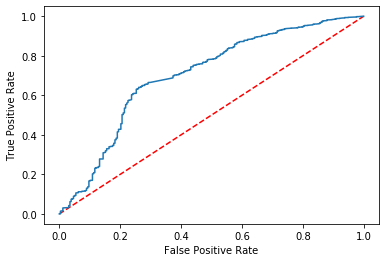

In [78]:
preds = predictions.select('feedback','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['feedback'])))
points = CurveMetrics(preds).get_curve('roc')

x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(x_val, y_val)
plt.show()

## Decsion Trees (200 Tokens)

In [ ]:
### Loading the model

In [138]:
dt = PipelineModel.load("Decsion_tree_10000")

predictions = dt.transform(trainingDF)
predictionAndLabels = predictions.select("feedback","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.6884533496660542


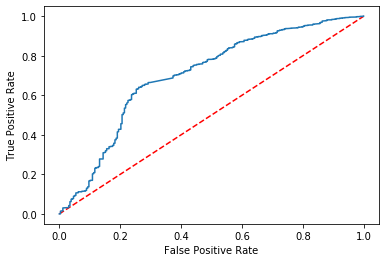

In [81]:
preds = predictions.select('feedback','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['feedback'])))
points = CurveMetrics(preds).get_curve('roc')

x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(x_val, y_val)
plt.show()

## Random forest classifier (200 Tokens)

In [125]:
rf = PipelineModel.load("random_forest_classifier_4000")

predictions = rf.transform(trainingDF)
predictionAndLabels = predictions.select("feedback","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.6846701729190522


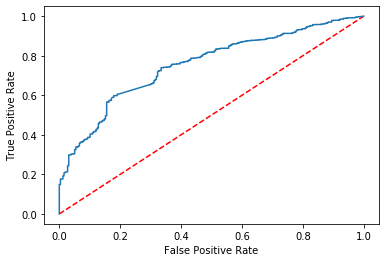

In [86]:
preds = predictions.select('feedback','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['feedback'])))
points = CurveMetrics(preds).get_curve('roc')

x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(x_val, y_val)
plt.show()

## Gradient-boosted tree classifier 


In [139]:
gbt = PipelineModel.load("Gradient_boosted_tree_10000")

predictions = gbt.transform(trainingDF)
predictionAndLabels = predictions.select("feedback","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.6884533496660542


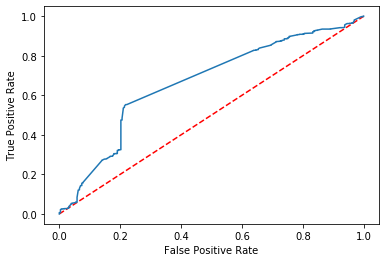

In [88]:
preds = predictions.select('feedback','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['feedback'])))
points = CurveMetrics(preds).get_curve('roc')

x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(x_val, y_val)
plt.show()

## Linear Support Vector Machine (200 tokens)

In [140]:
lsvm = PipelineModel.load("Linear_Support_Vector_Machine_10000")

predictions = lsvm.transform(trainingDF)
predictionAndLabels = predictions.select("feedback","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.5347724925081149


## Naive Bayes

In [142]:
nb = PipelineModel.load("Naive_Bayes_10000")

predictions = nb.transform(trainingDF)
predictionAndLabels = predictions.select("feedback","prediction").rdd
metrics = BinaryClassificationMetrics(predictionAndLabels)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.5541062292494421
